Author: Abdulrahman Altahhan, Feb 2023.

The notebook use a library of functionality in RL that aims for simplicity and general insight into how algorithms work, these libraries are written from scratch using standard python libraries (numpy, matplotlib etc.).
Please note that you will need to take the consent from the author to use the code for research, commercially or otherwise.

# Lesson 10- Eligibility Traces for Approximate Prediction and Control

**Learning outcomes**

1. understand the basic idea of the forward offline λ-return algorithm and its average all possible n-step updates
1. understand the basic idea of a backward implementation of λ-return in an online algorithm via eligibility traces 
1. understand how eligibility traces achieve a trade-off between full bootstrapping TD(0) and no bootstrapping MC=TD(1)
1. appreciate that eligibility traces are done on the component level when dealing with function approximation

**Reading**:
The accompanying reading of this lesson is **chapters 10 and 12** of our text book available online [here](http://incompleteideas.net/book/RLbook2020.pdf). Please note that we explain the ideas of this topic from a practical perspective and not from a theoretical perspective which is already covered in the textbook.

This lesson tackles eligibility traces as a new algorithmic mechanism to achieve more in our online updates. This mechanism allows us to efficiently implement RL algorithms that perform n-step bootstrapped learning without waiting for or accessing the previous n steps. Instead, we maintain a set of parameters updated regularly online each time an agent visits a state. Then this vector representing recently visited states will be sued to update the weights instead of the simple state vector. Eligibility traces are a powerful trick often used in classical RL.
Ok, let us get started...

In [1]:
%matplotlib inline

In [1]:
import nbimporter
from Lesson9_ApproximateControl import *
from math import floor

Note that we imported the Grid and the other environments from the Function approximation lesson because we are dealing with vectorised environment form now on.

# Prediction with Eligibility Traces

## TD(λ)
TD(λ) uses eligibility traces which allow us to implement the λ-return algorithm more efficiently in a straightforward and online manner! Refer to section 12.2. This is an online algorithm. Surprisingly, we can obtain the average of an offline set of all n-step TD updates. The equivalence is only guaranteed for the offline case. Nevertheless, the online case works just fine. The next section will tackle the true online, which addresses this shortcoming. 
The accumulating eligibility trace takes the form. 

$z_{t} = \gamma\lambda z_{t-1} + ∇\hat{v}(S_t, w_t)$

while for the update, we replace the gradient with the eligibility vector. Note that this type of eligibility trace has the same gradient requirement regarding storage and processing time.

$\delta_{t} = R_{t+1} + \gamma \hat{v}(S_{t+1},w_t) - \hat{v}(S_t,w_t)$

$w_{t+1} = w_{t} + \alpha\delta_{t}z_{t}$

The eligibility traces need to be initialised at the start of each episode, and we achieve that by using our step0 function.

In [2]:
class TDλ(MRP):
    def __init__(self, λ=.5, **kw):
        super().__init__(**kw)
        self.λ = λ
    
    def step0(self):
        self.z = self.w*0

    # ----------------------------- 🌖 online learning ----------------------    
    def online(self, s, rn,sn, done, *args): 
        α, γ, λ = self.α, self.γ, self.λ
        self.z = λ*γ*self.z + self.ΔV(s)
        self.w += α*(rn + (1-done)*γ*self.V(sn) - self.V(s))*self.z
        

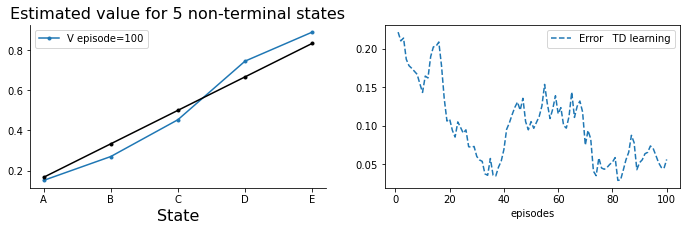

In [4]:
TDλwalk = TDλ(env=vrandwalk(), λ=.9, α=.05, episodes=100, v0=.5, **demoV()).interact(label='TD learning')

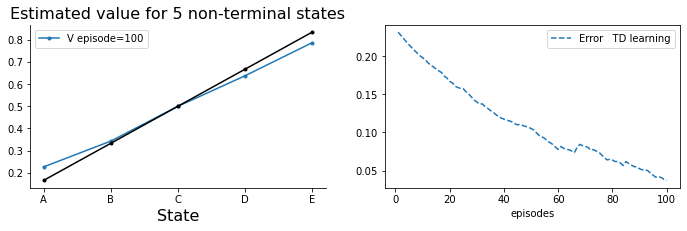

In [5]:
TDwalk = TD(env=vrandwalk(), α=.03, episodes=100,  v0=.5, **demoV()).interact(label='TD learning')

As we can see TD(λ) can converge faster than TD as it compresses several TD updates in each of its updates. This leads to the jittery behaviour that usually makes us reduce the learning rate but we can achieve more updates in less episodes in general. The other downside is that we have to tune the hyper parameter λ which can take more effort. 

## True Online TD(λ) and Dutch Traces
We implement the True online TD(λ) algorithm in this section. This algorithm guarantees an equivalence between the online and the offline cases, and it was hailed as an important step towards implementing a multi-step prediction algorithm that is both efficient and sound. in particular, it guarantees an equivalence between the offline λ-return algorithm (which takes the average of all possible n-step updates) and the true online TD(λ)! The justification or proof is quite involved. Please refer to sections 12.5 and 12.6 of the book. you can also have a look at the original true TD [paper](https://proceedings.mlr.press/v32/seijen14.html) and subsequent [paper](https://www.jmlr.org/papers/volume17/15-599/15-599.pdf) the latter is packed with useful information.

The drawback is that it can only be applied on a linear approximation and not on any general one as TD(λ), but it is a step in the right direction until researchers find a way to do it also for the nonlinear function approximator as well (such as neural networks). 

We need to handle an eligibility trace variable (Dutch trace), the size of which is identical to the weights. The update rule is given in equation 12.11, and its justification/deduction can be read from section 12.5. which shows the formula for Dutch traces.

Dutch traces are available when we use linear function approximation. They perform better than the classical accumulated eligibility traces. They take the form of 

$z_{t} = \gamma\lambda z_{t-1} + (1-\alpha\gamma\lambda z_{t-1}^\top x_{t})x_{t}$

The update takes the form:

$\delta_{t} = R_{t+1} + \gamma \hat{v}(S_{t+1},w_t) - \hat{v}(S_t,w_t)$

$w_{t+1} = w_{t} + \alpha\delta_{t}z_{t} + \alpha( w_{t}^\top x_{t} - w_{t-1}^\top x_{t})(z_{t} - x_{t})$

When we implement the true online TD(λ) algorithm, we save computation by saving the result of $vo=w_{t-1}^\top x_{t}$ instead of storing $w_{t-1}$.

In [6]:
class trueTDλ(MRP):
    def __init__(self, λ=.5, **kw):
        super().__init__(**kw)
        self.λ = λ

    def step0(self):
        self.z = self.w*0
        self.vo = 0
    # ----------------------------- 🌖 online learning ----------------------    
    def online(self, s, rn,sn, done, *args): 
        α, γ, λ = self.α, self.γ, self.λ
        
        self.v = self.V(s)
        self.vn= self.V(sn)*(1-done)
        δ = rn + γ*self.vn - self.v
        self.z = λ*γ*self.z + (1-α*λ*γ*self.z.dot(s))*s
        
        self.w += α*(δ + self.v - self.vo )*self.z - α*(self.v - self.vo)*s
        self.vo = self.vn
        

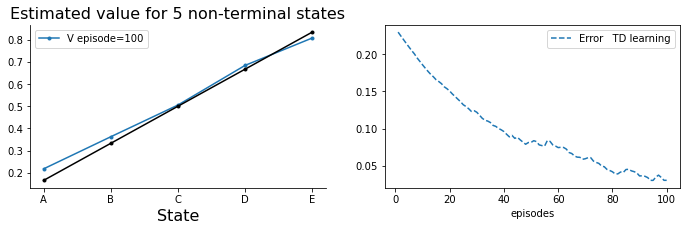

In [7]:
trueTDλwalk = trueTDλ(env=vrandwalk(), α=.03, λ=.4, episodes=100, v0=.5, **demoV()).interact(label='TD learning')

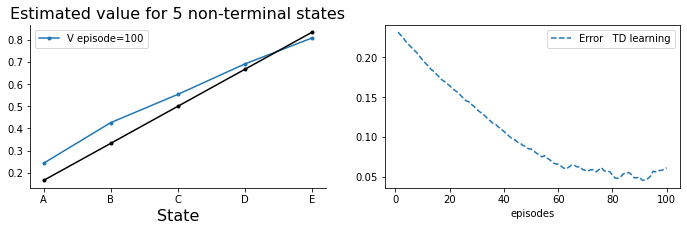

In [8]:
TDwalk = TD(env=vrandwalk(), episodes=100, α=.03,  v0=.5, **demoV()).interact(label='TD learning')

As we can see true online TD(λ) can converge faster than TD. Again, similar to TD(λ) this leads to the jittery behaviour that usually entails reducing the learning rate, but we can achieve more updates in less episodes in general. The other downside is that we have to tune the hyper parameter λ which can take more effort. This leads to our next set of experiments in order to study how the algorithms reacts to both λ and α and whether there is a sweet spot that one can aim for.

### Model selection for trueTDλ: Tuning λ and α

We will test our true online TD on the random walk with function approximation. Due to the dot product, some of the learning rate α might be too much for the algorithm when using high λ values, and they will cause overflow. This is not a problem as we are just testing the limits of the algorithm, but to avoid doing so, we added a conditional statement to limit the values of α for high λ values.

In [9]:
def TDλ_MC_Walk_αcompare(algorithm=TDλ, label='TD(λ)', runs=10):
    
    steps0 = list(np.arange(.001,.01,.001))
    steps1 = list(np.arange(.011,.2,.02))
    steps2 = list(np.arange(.25,1.,.05))

    αs = np.round(steps0 +steps1 + steps2, 2)
    #αs = np.arange(0,1.05,.1) # quick testing
    
    plt.xlim(-.02, 1)
    plt.ylim(.24, .56)
    plt.title('%s RMS error Average over 19 states and first 10 episodes'%label)
    for λ in [0, .1, .4, .8, .9, .95, .975, .99, 1]:
        end=34 if λ<.975 else (-3 if λ<.99 else -10)
        compare = Compare(algorithm=algorithm(env=vrandwalk_(), v0=0, λ=λ, episodes=10), 
                                  runs=runs, 
                                  hyper={'α':αs[:end]}, 
                                  plotE=True).compare(label='λ=%.3f'%λ)

    if algorithm==trueTDλ:
        compare = Compare(algorithm=MC(env=vrandwalk_(), v0=0, episodes=10), 
                                  runs=runs, 
                                  hyper={'α':αs}, 
                                  plotE=True).compare(label='MC ≡ TD(λ=1)', frmt='-.')
    


Ok let us now apply the TD(λ) on our usual random walk to see if it behaves as expected. We are using the default vectroised Grid which is equivalent to the tabular case. 

100%|██████████| 24/24 [00:02<00:00,  9.44it/s]


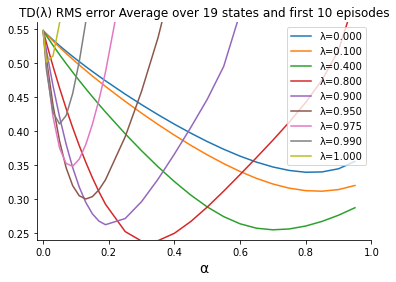

In [10]:
TDλ_MC_Walk_αcompare(TDλ, runs=5)

Ok that seems good and is follows to the usual pattern of n-step algorithm. Note that we have executed for a couple of runs which explains the overshooting of the figure boundaries. Let us now contrast TD(λ) and true online TD(λ) on the same random walk problem. 

In [11]:
def TDλ_vs_trueonlineTDλ(runs):
    plt.figure(figsize=[15,4]).tight_layout()
    
    plt.subplot(121); TDλ_MC_Walk_αcompare(TDλ, label='TD(λ)', runs=runs)
    plt.subplot(122); TDλ_MC_Walk_αcompare(trueTDλ, label='true online TD(λ)', runs=runs)

This time we will run both for longer runs.

100%|██████████| 34/34 [00:02<00:00, 12.11it/s]


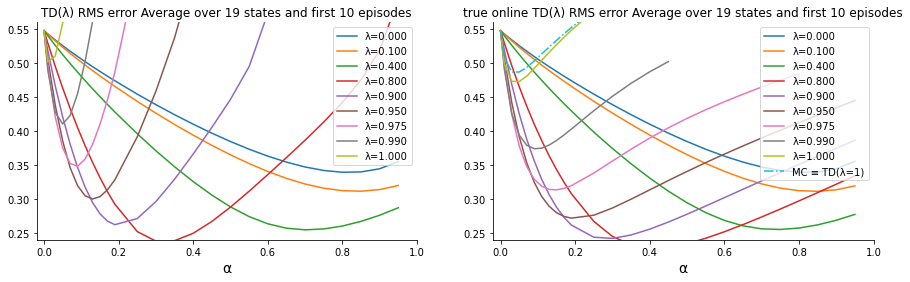

In [12]:
TDλ_vs_trueonlineTDλ(runs=5)

### Notes on the convergence of TD with Function Approximation
As we can see, the true online has more stretched curves indicating that they are more stable with a wider range of learning rates. This is due to the equivalence between the online and offline cases, which guarantees convergence and more stability than TD(λ). 

Note that TD(λ)is proven to converge for the offline case, not the online case. True online TD(λ) also performs slightly better than TD(λ). Note, of course, that when λ=0, we go back to our usual TD algorithm. Finally, note that TD(0) with linear function approximation is proven to converge under the usual conditions of stochastic approximation theory 2.7 the learning rate α ($\sum_{i=1}^{\infty}\alpha_i = \infty $ and $\sum_{i=1}^{\infty}\alpha_i^2 <\infty $), see page 206 Proof of Convergence of Linear TD(0) in the book.

# Control with Eligibility Traces
We move next to the control realm and write a Sarsa(λ) with an approximate value function. The idea is similar to Sarsa(0) that we have written in the previous lesson (we called is just Sarsa there). We need, however, this time to take care of an extra variable that holds the eligibility traces, which has a size identical to the weights, so each action has its own eligibility trace. 

The eligibility traces need to be initialised at the start of each episode, and we achieve that by using our step0 function. The update is per equation 12.5 in the book, but we must apply it for the eligibility trace corresponding to the current action.

Note that the book assumes that we concatenate all the eligibility traces by encoding a large state representation that assigns 0 to all components that do not correspond with the current action. We felt that this was vague and made the implementation unclear.

## Sarsa(λ)

In [3]:
class Sarsaλ(MDP()):
    def __init__(self, λ=.5, **kw):
        super().__init__(**kw)
        self.λ = λ
        self.step = self.step_an # for Sarsa we want to decide the next action in time step t
    
    def step0(self):
        self.Z = self.W*0
    # ----------------------------------------🌖 online learning ----------------------------------------
    def online(self, s, rn,sn, done, a,an):
        self.Z[a] = self.λ*self.γ*self.Z[a] + self.ΔQ(s)
        self.W[a] += self.α*(rn + (1-done)*self.γ*self.Q(sn,an)- self.Q(s,a))*self.Z[a]


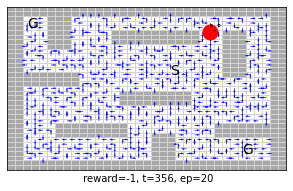

KeyboardInterrupt: 

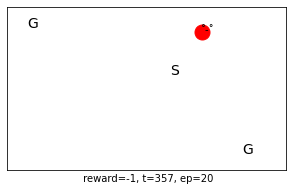

In [4]:
sarsa = Sarsa(env=vmaze(reward='reward1'), α=.05, episodes=20, seed=10, **demoQ()).interact()

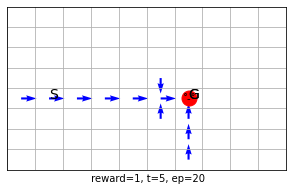

In [15]:
sarsa.underhood = 'maxQ'
sarsa.render()

In [16]:
sarsa.Q_(10,1)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.50000000e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.00209380e-05, 6.10730839e-03,
       5.14226101e-02, 3.25250643e-01, 1.58015574e+00, 5.59873331e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [67]:
#sarsa = Sarsa(env=vgrid(reward='reward1'), α=0.5, episodes=200, seed=0, **demoQ()).interact()

#sarsa = Sarsa(env=vgrid(reward='reward1'), α=0.5, episodes=200, seed=0, **demoQ()).interact()
sarsa = Sarsa(env=vgrid(reward='reward1'), α=0.5, episodes=400, seed=0, **{'plotT': False, 'visual': False, 'underhood': 'maxQ'}).interact()

step 4189, episode 399, r -5.00, mean r last 10 ep -6.20, ε 0.10


In [66]:
#sarsaλ = Sarsaλ(env=vgrid(reward='reward1'),α=0.5, episodes=200, seed=0, **demoQ()).interact()
sarsaλ = Sarsaλ(env=vgrid(reward='reward1'),α=0.5, episodes=400, seed=0, **{'plotT': False, 'visual': False, 'underhood': 'maxQ'}).interact()
print(sarsaλ)

step 3575, episode 399, r -3.00, mean r last 10 ep -3.80, ε 0.10


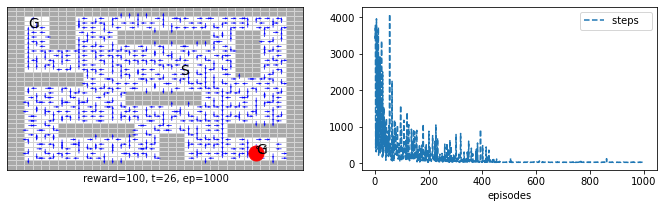

In [8]:
sarsaλ = Sarsaλ(env=vmaze(reward='reward100'), λ=.1, episodes=1000, seed=10, **demoQ()).interact()

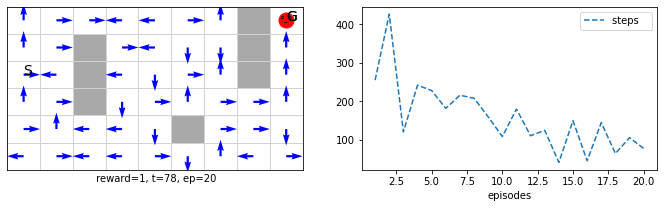

In [20]:
sarsaλ = Sarsaλ(env=vmaze(reward='reward1'), λ=.5, episodes=20, seed=10, **demoQ()).interact()

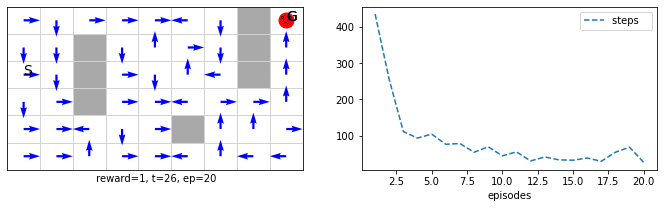

In [21]:
sarsaλ = Sarsaλ(env=vmaze(reward='reward1'), λ=.9, episodes=20, seed=10, **demoQ()).interact()

Note how some of the cells arrows that represent the policy is being updated without being visited in the current time step this is due to the effect of eligibility traces accumulating states in previous steps that are *eligible* for updating.

## True Online Sarsa(λ)

We implement the True online Sarsa(λ) algorithm in this section. This algorithm guarantees an equivalence between the online and the offline cases, and it is hailed as an important step towards implementing a sound multi-step control algorithm that is both efficient and sound. The main drawback that we have is that it can only be applied to a linear approximation, not to any general one as Sarsa(λ), but it is a step in the right direction until researchers find a way to do it also for the nonlinear functions as well (such as neural networks). We need to handle an eligibility trace variable, the size of which is identical to the weights, so each action has its own eligibility trace. The update rule is given in equation 12.11, and its justification/deduction can be read from section 12.5.
Note that in our implementation. 

- qo is an old action-value estimation for the current state
- qn is the action-value estimation for the next    state
- q  is the action-value estimation for the current state


In [6]:
class trueSarsaλ(MDP()):
    def __init__(self, λ=.5, **kw):
        super().__init__(**kw)
        self.λ = λ
        self.step = self.step_an # for Sarsa we want to decide the next action in time step t
    
    def step0(self):
        self.Z = self.W*0
        self.qo = 0
    # ----------------------------------------🌖 online learning ----------------------------------------
    def online(self, s, rn,sn, done, a,an):
        
        α, γ, λ = self.α, self.γ, self.λ
        
        self.q = self.Q(s,a)
        self.qn= self.Q(sn,an)*(1-done)
        δ = rn + γ*self.qn - self.q
        self.Z[a] = λ*γ*self.Z[a] + (1-α*λ*γ*self.Z[a].dot(s))*s
        
        self.W[a] += α*(δ + self.q - self.qo )*self.Z[a] - α*(self.q - self.qo)*s
        self.qo = self.qn


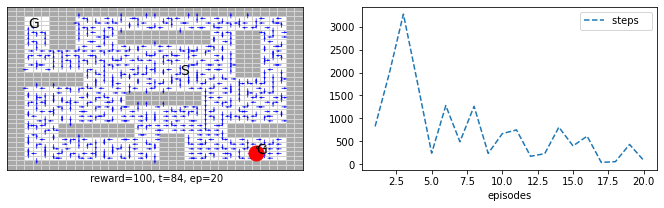

In [9]:
truesarsaλ = trueSarsaλ(env=vmaze(reward='reward100'), λ=.9, episodes=20, seed=10, **demoQ()).interact()

In [31]:
print(vmaze())


Note how true online Sarsa(λ) performs better than Sarsa(λ) which in turn performs better than Sarsa(0) which has been covered in previous lessons.


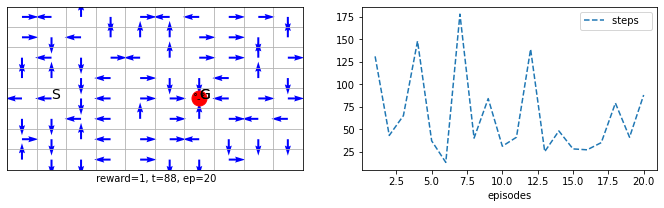

In [24]:
sarsa = Sarsa(env=vgrid(reward='reward1'), episodes=20, seed=10, **demoQ()).interact()

Let us now apply the MountainCarTiledRuns on the trueSarsaλ to see how it behaves with different λ values.

In [25]:
def MountainCarTiledRuns_λ(runs=20, algo=trueSarsaλ, env=tiledMountainCar):

    plt.title(algo.__name__+' on mountain car: comparison of λ and α with the same 8x8x8 tilings')

    for λ, α in zip([0, .8], [.5, .3]):
        sarsaRuns = Runs(algorithm=algo(env=env(ntiles=8, ntilings=8), λ=λ, α=α/8,episodes=500, ε=0), 
                         runs=runs, seed=1, plotT=True).interact(label='λ=%.2f, α=%.2f/8'%(α,α))
    plt.ylim((10**2,10**3))
    plt.yscale('log')
    plt.show()
    
figure_10_3_λ = MountainCarTiledRuns_λ

100%|██████████| 20/20 [01:04<00:00,  3.24s/it]


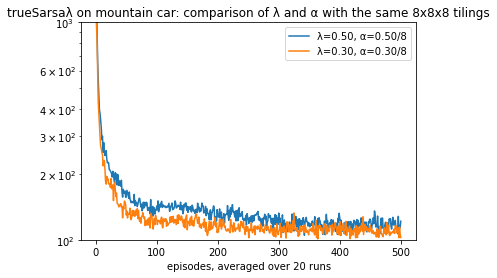

Wall time: 2min 17s


In [26]:
%time figure_10_3_λ(env=tiledMountainCar, algo=trueSarsaλ)

As we can see both n-step TD and true online TD(λ)  have perform very similarly which confirms our starting premise, which is to design an algorithm that can perform n-step TD updates but which does not requires the steps delay.

In [27]:
def MountainCarTiledCompare_λ(runs=3,  algo=trueSarsaλ, env=IHTtiledMountainCar): # 10
    
    xsticks = np.array([0, .5 , 1, 1.5, 2, 2.3])/8
    plt.xticks(ticks=xsticks, labels=xsticks*8)
    plt.yticks([180, 200, 220, 240, 260, 280, 300])
    plt.ylim(170, 300)
    plt.title('Steps per episode averaged over first 50 episodes for '+algo.__name__)

    for λ in [0, .68, .84, .92]:#, .96, .98, .99]:
        if λ>=.0: αs = np.arange(.1,  1.8,  .1)
        if λ>=.6: αs = np.arange(.1,  1.8,  .1)
        if λ>=.8: αs = np.arange(.1,  1.8,  .1)
        if λ>=.9: αs = np.arange(.1,  1.8,  .15)
        if λ>=.98: αs = np.arange(.1,  .7,  .15)
        if λ>=.98: αs = np.arange(.1,  .7,  .07)
    
        Compare(algorithm=algo(env=env(ntilings=8, ntiles=8), λ=λ, episodes=50, ε=0), runs=runs, 
                                  hyper={'α':αs/8}, 
                                  plotT=True).compare(label='λ=%.2f'%λ)
    plt.xlabel(r'$\alpha \times 8$ since we used 8 tiles for each tilings')
    plt.show()
    

figure_12_10 = MountainCarTiledCompare_λ

## Comparing Sarsa(λ) with n-step Sarsa

100%|██████████| 12/12 [00:22<00:00,  1.84s/it]


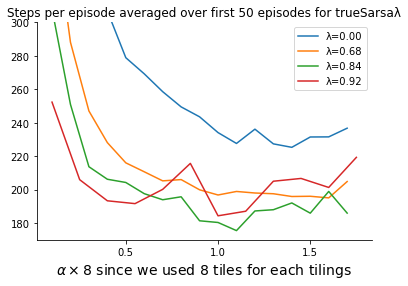

Wall time: 2min 6s


In [28]:
%time MountainCarTiledCompare_λ()

100%|██████████| 13/13 [01:11<00:00,  5.48s/it]


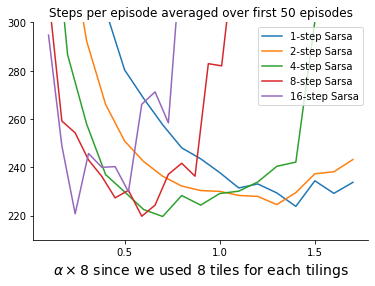

Wall time: 5min 20s


In [29]:
%time MountainCarTiledCompare_n()

Note that we have not used hashing and hence our range is different from the one stated in the book. Nevertheless, the pattern is maintained.

## Conclusion
In this lesson, we covered an important mechanism in RL that allows us to efficiently implement n-step methods online without waiting for n-steps, as we did earlier in the tabular case. Eligibility traces are very useful when we use the approximate function to estimate the value function in RL, but they can also be used in the tabular case. We have seen the classic Sarsa() for control, which can be used with any function approximation, including a neural network. Finally, we have seen how True Online Sarsa(λ) behaves and that it is more efficient and holds a guarantee of the online and offline equivalency of TD(), which took several years to achieve in the RL development. True online TD(λ) only applies to the linear function approximation, and there is no counterpart for it when we move to neural networks. In this lesson, you also saw how to deal with a continuous state space using function approximation and how to apply previous concepts to a more difficult control problem.

## Your turn
1. apply TD(λ) and true online TD(λ) on the 1000 tiled random walk environment (below we show you how to do that on the 1000 random walk), make sure to set α Appropriately around .002.
2. apply Sarsa(λ) and true online Sarsa(λ) on the tiled mountain car environment and confirm that its behaviour is similar to the n-step Sarsa.



## Challenge
1. Implement a true online Q-learning algorithm. Note that you would need to restart the traces when the max action is not the same as the selected action since you cannot blame the pure greedy policy (the one Q-learning is learning about) for what the e-greedy policy took to explore, refer to the [paper](https://www.jmlr.org/papers/volume17/15-599/15-599.pdf)
1. Can you think of a reason why we did not implement an offline version of the trueTDλ?
1. Implement and offline of trueTDλ and TDλ and compare between them and their online counterparts do you see a difference between them.